In [1]:
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import pytesseract as tess
tess.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
from imutils.object_detection import non_max_suppression
from cv2.dnn import readNet
from cv2.dnn import blobFromImage
import plotly.express as plt

In [2]:
PII_from_images1=[]

In [3]:
list_images=["c1.jpeg","c2.png","c3.jpg","c4.jpg","e1.jfif","e2.jfif","e3.jpg","e4.jpg","e5.jpg","e6.jfif"]

In [4]:
for i in range(1,15):
    list_images.append("p"+str(i)+".jpg")

In [5]:
def ratio_check(a,w,h):
    r=float(w/h)
    if(r<1):
        r=1/r
    if((a<1063.62 or a>73862.5)or(r<3 or r>6)):
        return False
    return True

def is_max_white(p):
    if(np.mean(p)>=115):
        return True
    return False
def ratio_and_rotation(r):
    (x, y),(w,h),ra=r
    if(w>h):
        a=-ra
    else:
        a=90+ra
    if(a>15 or w==0 or h==0):
         return False
    area=h*w
    if(not ratio_check(area,w,h)):
        return False
    return True

def process(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
    num_contours = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if(num_contours):
        contour_area = [cv2.contourArea(c) for c in num_contours]
        max_cntr_index = np.argmax(contour_area)
        max_cnt = num_contours[max_cntr_index]
        max_cntArea = contour_area[max_cntr_index]
        x,y,w,h = cv2.boundingRect(max_cnt)
        if(ratio_check(max_cntArea,w,h)):
            final_img = thresh[y:y+h, x:x+w]
            return final_img,[x,y,w,h]
    return image, None

def vehicle_numbers(img):
    img = cv2.imread(img)
    img2 = cv2.GaussianBlur(img, (3,3), 0)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)    
    img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = img2.copy()
    cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    num_contours = cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_SIMPLE)[0]
    cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)


    for cnt in num_contours:
        min_rect = cv2.minAreaRect(cnt)
        if ratio_and_rotation(min_rect):
            x,y,w,h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h,x:x+w]
            #print("Number  identified number plate...")
            #cv2.imshow("num plate image",plate_img)
            if(is_max_white(plate_img)):
                clean_plate, rect = process(plate_img)
                if(rect):
                    fg=0
                    x1,y1,w1,h1 = rect
                    x,y,w,h = x+x1,y+y1,w1,h1
                    # cv2.imwrite("clena.png",clean_plate)
                    plate_im = Image.fromarray(clean_plate)
                    text = tess.image_to_string(plate_im)
                    return(str(text))


In [6]:
for i in list(list_images)[0:4]:
    PII_from_images1.append(vehicle_numbers("images\\"+i))

In [7]:
#part 2

def process(img):
    m, n = img.shape[: 2]
    img = cv2.resize(img,
                    (n*600//(m+n),m*600//(m+n)),
                    interpolation=cv2.INTER_CUBIC)
    
    # kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5, 5))
    # img = cv2.dilate(img, kernel, iterations=1)
    # img = cv2.erode(img, kernel, iterations=1)
    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    # img = cv2.GaussianBlur(img, (5,5), 0)
    # img = cv2.medianBlur(img,5)
    img = cv2.bilateralFilter(img,9,75,75)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return img
    

def east_model_detect(img, original, i, j):
    n, m = original.shape[: 2]
    (height, width) = img.shape[: 2]

    rW = height / 448
    rH = width / 448

    resized_img = cv2.resize(img, (448, 448))
    (height, width) = resized_img.shape[: 2]

    model = readNet("east_model.pb")
    blob = blobFromImage(img,
                         1.0,
                         (width, height),
                         (123.68, 116.78, 103.94),
                         swapRB = True,
                         crop = False)

    out_layers = []
    out_layers.append("feature_fusion/Conv_7/Sigmoid")
    out_layers.append("feature_fusion/concat_3")

    model.setInput(blob)
    output = model.forward(out_layers)

    scores = output[0]
    geometry = output[1]

    (num_rows, num_cols) = scores.shape[2: 4]
    rects = []
    confidences = []
    texts = []
    for y in range(0, num_rows):
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(0, num_cols):
            if scores_data[x] < 0.75:
                continue
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x_data0[x] + x_data2[x]
            w = x_data1[x] + x_data3[x]

            endX = int(offsetX + (cos * x_data1[x]) + (sin * x_data2[x]))
            endY = int(offsetY - (sin * x_data1[x]) + (cos * x_data2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scores_data[x])

    boxes = non_max_suppression(np.array(rects),
                                probs = confidences)
    ori=original.copy()
    if len(boxes) > 0:
        for (startX, startY, endX, endY) in boxes:
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
            pb = int(np.abs(startX - endX) * 0.1)
            ph = int(np.abs(startY - endY) * 0.1)
            p = pb if pb > ph else ph
            lx = startX - p if startX- p >= 0 else 0
            hx = endX + 1 + p if startX- p < m else m
            ly = startY - p if startY- p >= 0 else 0
            hy = endY + 1 + p if startY - p < n else n
            rect = original[ly: hy,
                            lx: hx]
            gray_rect = cv2.cvtColor(rect, cv2.COLOR_BGR2GRAY)
            processed_rect = process(gray_rect)
            texts.append(tess.image_to_string(processed_rect))
            if(i==10):
                cv2.rectangle(ori,
                              (lx, ly),
                              (hx, hy),
                              (0, 255, 255),
                              2)
                cv2.imshow("example", ori)
    return(texts)

In [8]:
img = cv2.imread("images/e1.jfif")
img = cv2.resize(img, (448, 448))
east_model_detect(img, img.copy(), 10, 1)
cv2.waitKey(0)

-1

In [9]:
PII_from_images2=[]

for i in list_images[4:]:
    img = cv2.imread("images/"+i)
    img = cv2.resize(img, (448, 448))
    PII_from_images2.append(east_model_detect(img, img.copy(), 1, 1))

In [10]:
import re

#regex
email_regex="(\S(\.|\w)+[@]+(\.|\w)+([.]\S*))"
phone_number_regex="[1-4]{1}[0-9]{7}|[0-9]{10}"
aadhar_number_regex="\d{4}\s\d{4}\s\d{4}"
pincode_regex="[1-9]{1}[0-9]{2}[0-9]{3}\D|\D[1-9]{1}[0-9]{2}\D{1}[0-9]{3}"
vehicle_number_regex="[A-Z]{2}[0-9]{1,2}(?:[A-Z])?(?:[A-Z]*)?[0-9]{4}|[A-Z]{2}"
named_entities_regex="[A-Z]{4,}|[A-Z]{1}[A-Za-z]{3,}|[a-z]{4,}"


regexes=[email_regex,phone_number_regex,aadhar_number_regex,pincode_regex,vehicle_number_regex,named_entities_regex]

dc_regex={}
dc_regex[email_regex]='Email IDs'
dc_regex[phone_number_regex]="Phone Numbers"
dc_regex[aadhar_number_regex]="Aadhar Numbers"
dc_regex[pincode_regex]="Pincodes"
dc_regex[vehicle_number_regex]="Vehicle numbers"
dc_regex[named_entities_regex]="Named Entities"

In [11]:
def remove_noise(j):
    j=j.replace("\n\x0c","")
    j=j.replace("\x0c","")
    j=j.replace("\n","")
    j=j.replace("\na","")
    j=j.replace("|","")
    j=j.replace("-"," ")
    j=j.replace(","," ")
    j=j.replace("“"," ")
    j=j.replace("'"," ")
    return(j)

In [12]:
PIIs=[]

for i in PII_from_images2:
    for j in i:
        j=remove_noise(j)
        if(len(j)>3):
            PIIs.append(j)

In [13]:
PIIs

['14 23844632',
 'ROOP',
 'NAGAR ',
 'Sa: «CS',
 '14  011 27616845',
 '14 276 16844  0:',
 'BURARI',
 'Mob.',
 'Peru lyuwy  Vi relive». 98119946',
 'h Distt.',
 'Rajiv',
 '‘Chowk',
 'Rangareddy  ©',
 '  Telangana',
 'MOTINAGAR',
 '900114',
 ' shastri',
 'delhi',
 'nagar:',
 'Delhi',
 '110002 ',
 'wWirtiwsv &SHAHDARA D',
 'EN Wine IRA DISTRICT_—_ —S — a  Ba Se ge wa',
 'LICE',
 'SMANVARA Diol: 011 22508164  4a',
 '‘ote Mel f',
 'STRICT  22506665',
 'STATION',
 'Rajiv',
 '‘Chowk',
 'Barakhamba R',
 'Road',
 'fy Onova',
 ' Athens ',
 ' Mandir',
 'alamy §',
 ' Kalkaji ',
 'Nagar',
 'Ramesh I',
 'Park',
 'Rajdhani_',
 'Laxmi I',
 'Nagar',
 'Patel',
 ' Nagar',
 'Kirti',
 'Nagar',
 'Place',
 ' Rajendra',
 'Netaji.',
 'Subhash ',
 'Place',
 'yCINEMAS',
 'P\\/R',
 'Bazar',
 'Chawri ',
 '0686579014',
 '+ com «',
 'DEKRA']

In [14]:
PIIs_final=[]

dc_output={}

for i in dc_regex.values():
    dc_output[i]=[]

for i in PIIs:
    for j in regexes:
        l=(re.findall(j,i))
        for k in l:
            if(len(k)>3):
                dc_output[dc_regex[j]].append(k)
                PIIs_final.append(k)


for j in PII_from_images1:
    j=remove_noise(j)
    if(len(j)>3):
        dc_output['Vehicle numbers'].append(j)
        


In [15]:
df_count={}
for i in dc_output.keys():
    df_count[i]=len(dc_output[i])
    


df_f={}
df_f['PIIs']=list(df_count.keys())
df_f['Counts']=list(df_count.values())

df=pd.DataFrame(df_f)
df

PIIs  Counts
0        Email IDs       0
1    Phone Numbers       5
2   Aadhar Numbers       0
3         Pincodes       3
4  Vehicle numbers       4
5   Named Entities      53

In [16]:
for i in dc_output.keys():
    print(i,":\n")
    for j in dc_output[i]:
        print(j)
    print("-----------------------------------------------------------------------")



Email IDs :

-----------------------------------------------------------------------
Phone Numbers :

23844632
27616845
22508164
22506665
0686579014
-----------------------------------------------------------------------
Aadhar Numbers :

-----------------------------------------------------------------------
Pincodes :

 276 168
110002 
508164 
-----------------------------------------------------------------------
Vehicle numbers :

 CGO4MF 2250
 DL3C AM 0857
gi 01 AS 9299
KL 215 8086
-----------------------------------------------------------------------
Named Entities :

ROOP
NAGAR
BURARI
Peru
lyuwy
relive
Distt
Rajiv
Chowk
Rangareddy
Telangana
MOTINAGAR
shastri
delhi
nagar
Delhi
Wirtiwsv
SHAHDARA
Wine
DISTRICT
LICE
SMANVARA
Diol
STRICT
STATION
Rajiv
Chowk
Barakhamba
Road
Onova
Athens
Mandir
alamy
Kalkaji
Nagar
Ramesh
Park
Rajdhani
Laxmi
Nagar
Patel
Nagar
Kirti
Nagar
Place
Rajendra
Netaji
Subhash
Place
CINEMAS
Bazar
Chawri
DEKRA
-----------------------------------------------------

More details for vehicle Numbers:
-----------------------------------------------------------------------
Vehicle Number:  CG 04 MF 2250



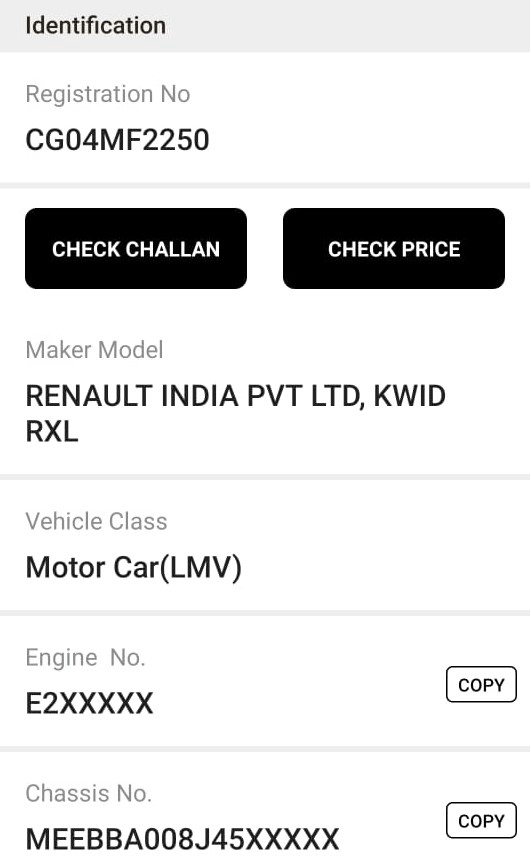


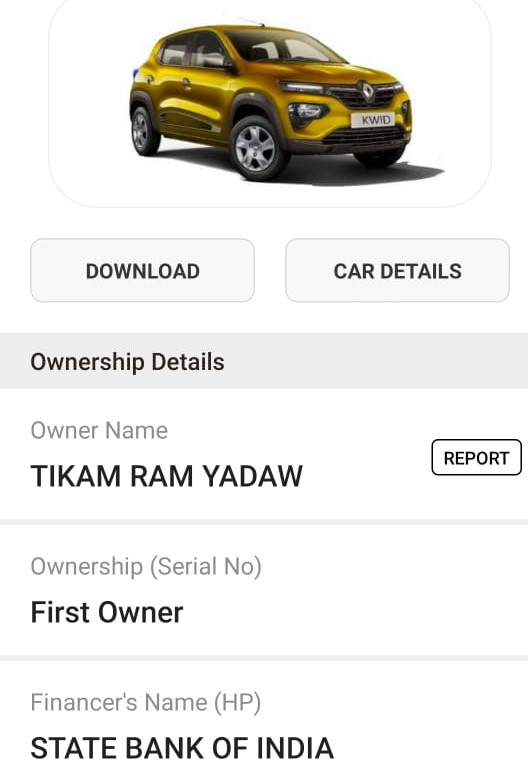


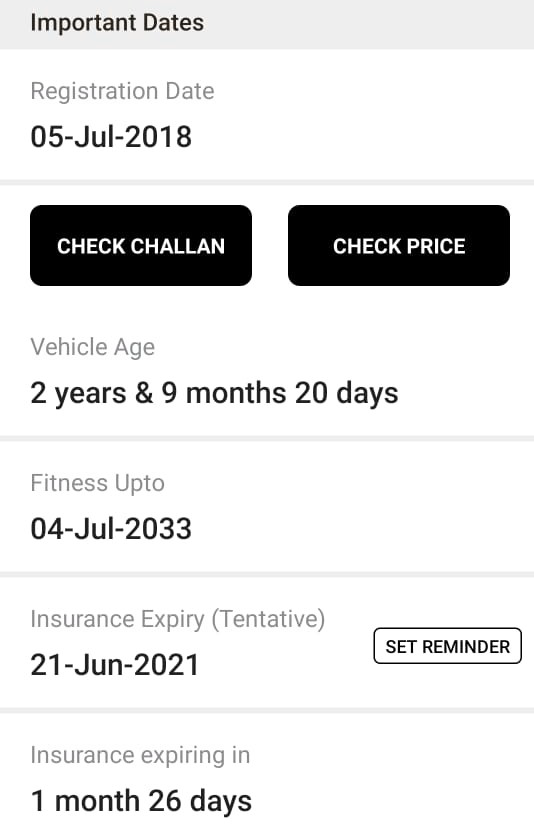


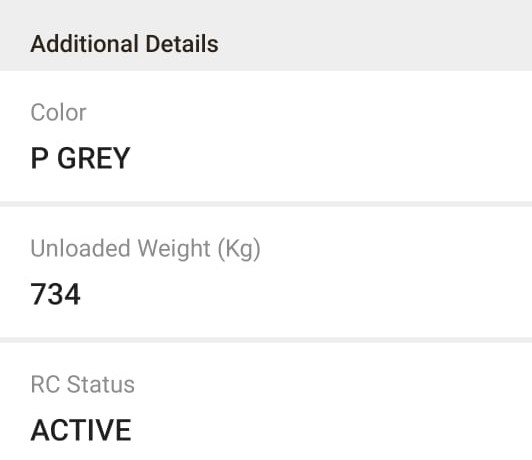


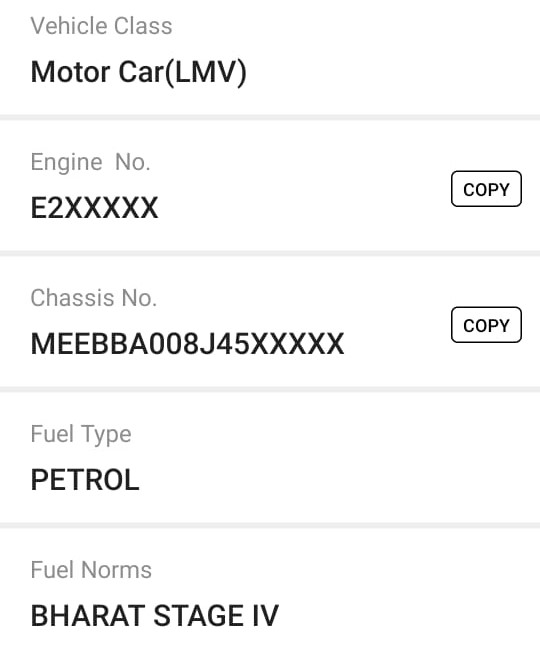


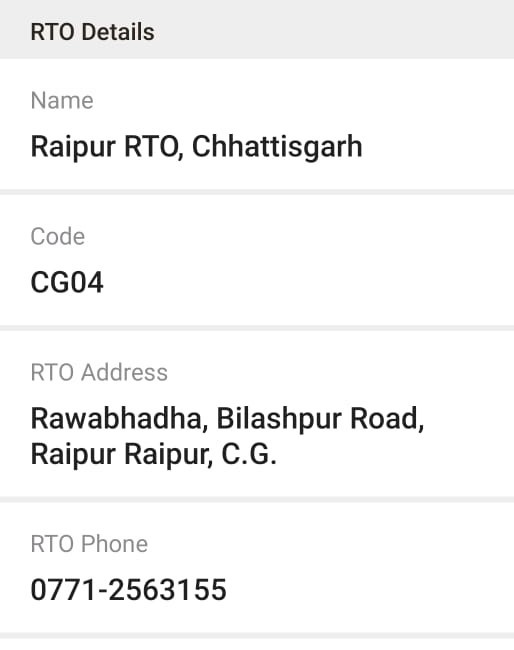

-----------------------------------------------------------------------
Vehicle Number:  DL 3C AM 0857



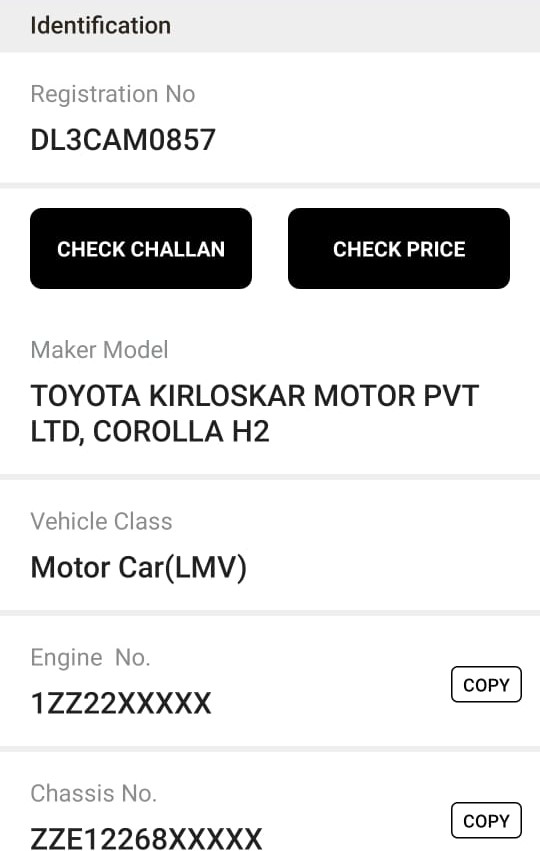


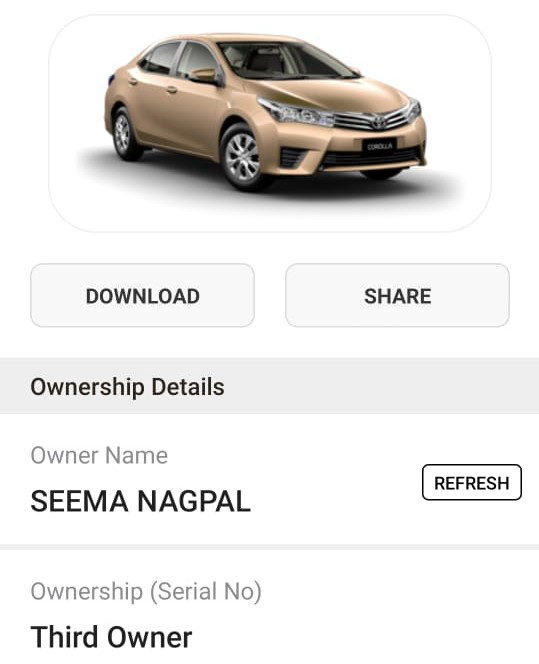


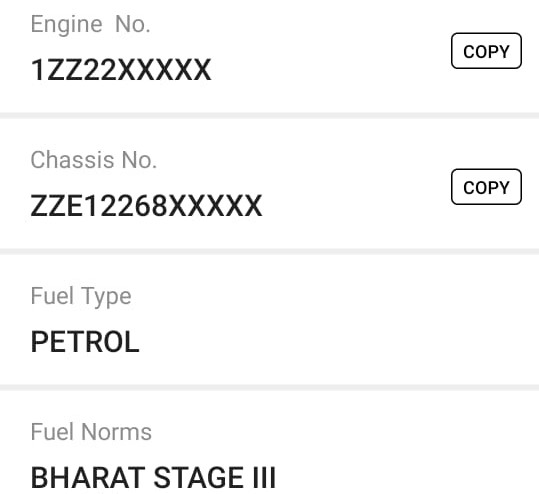


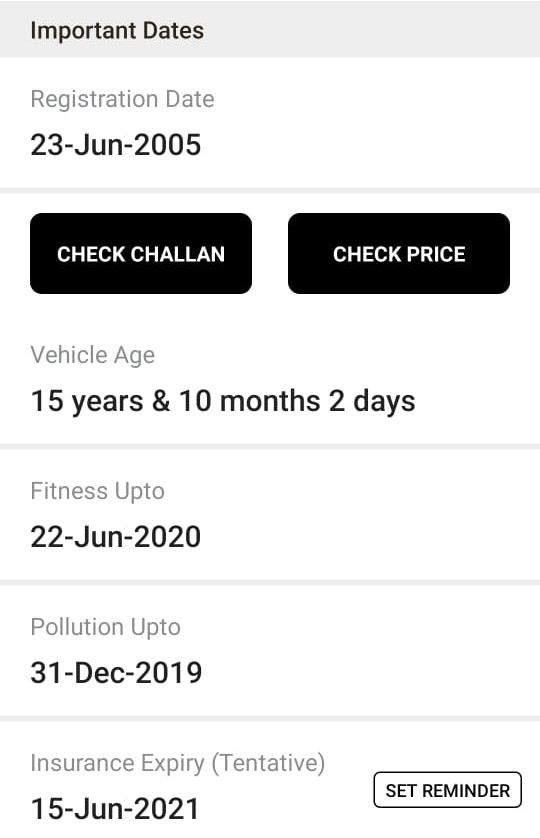


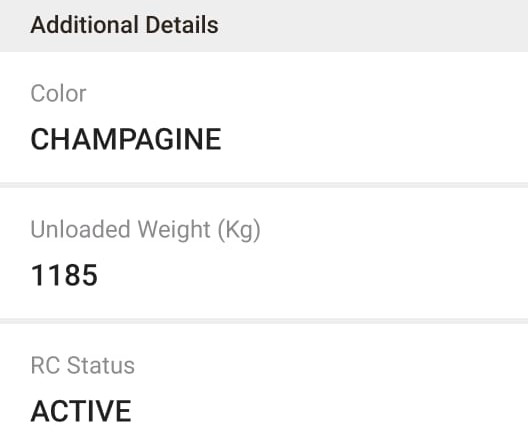


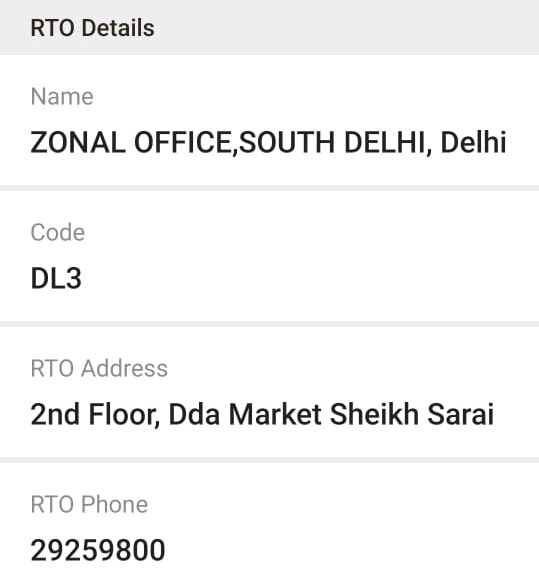


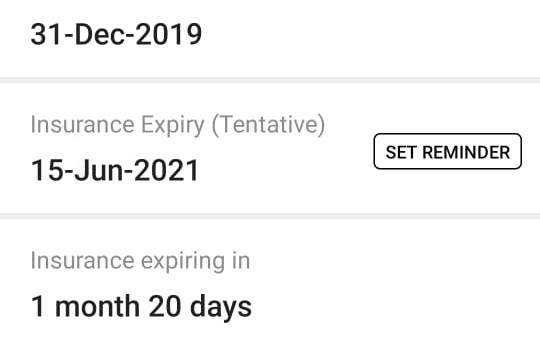

-----------------------------------------------------------------------
Vehicle Number:  KL 21S 8086



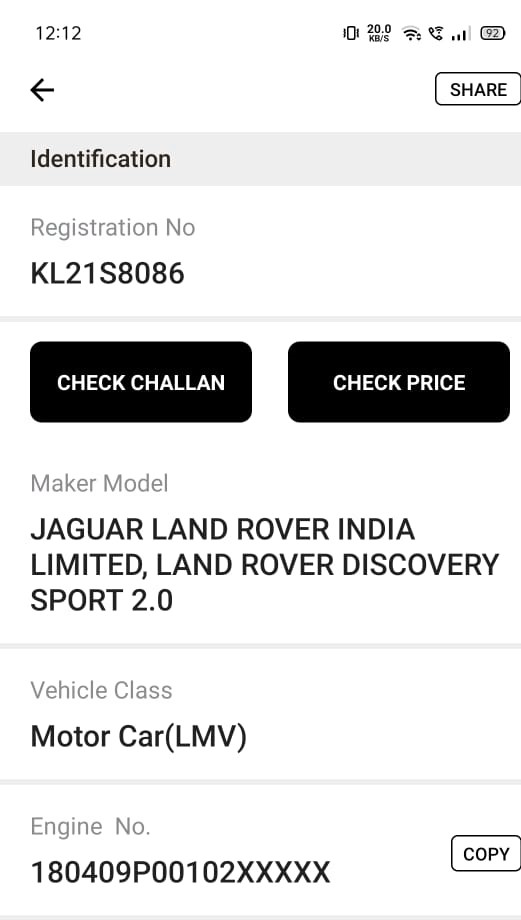


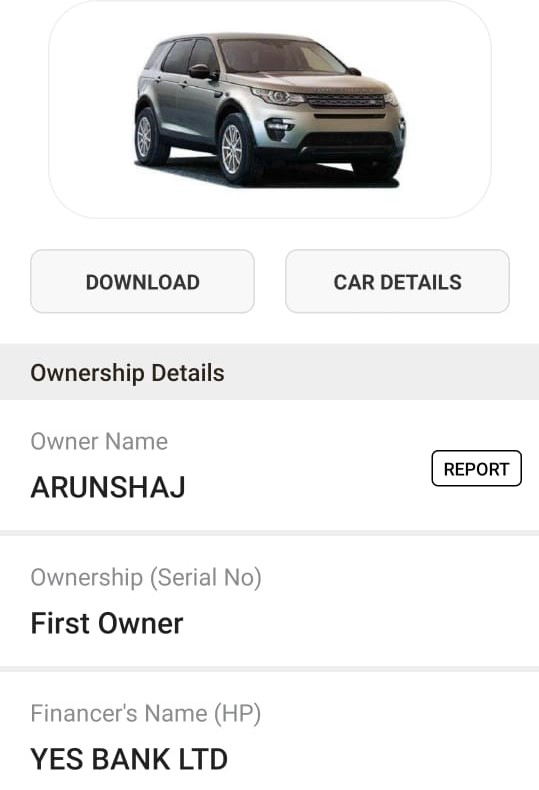


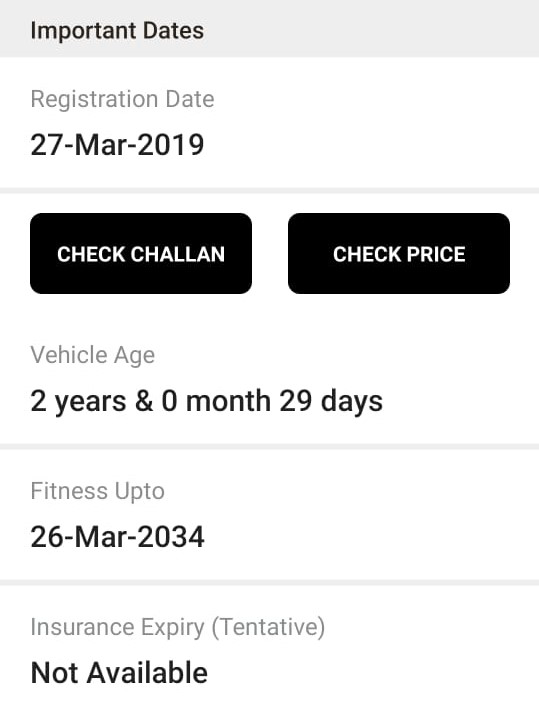


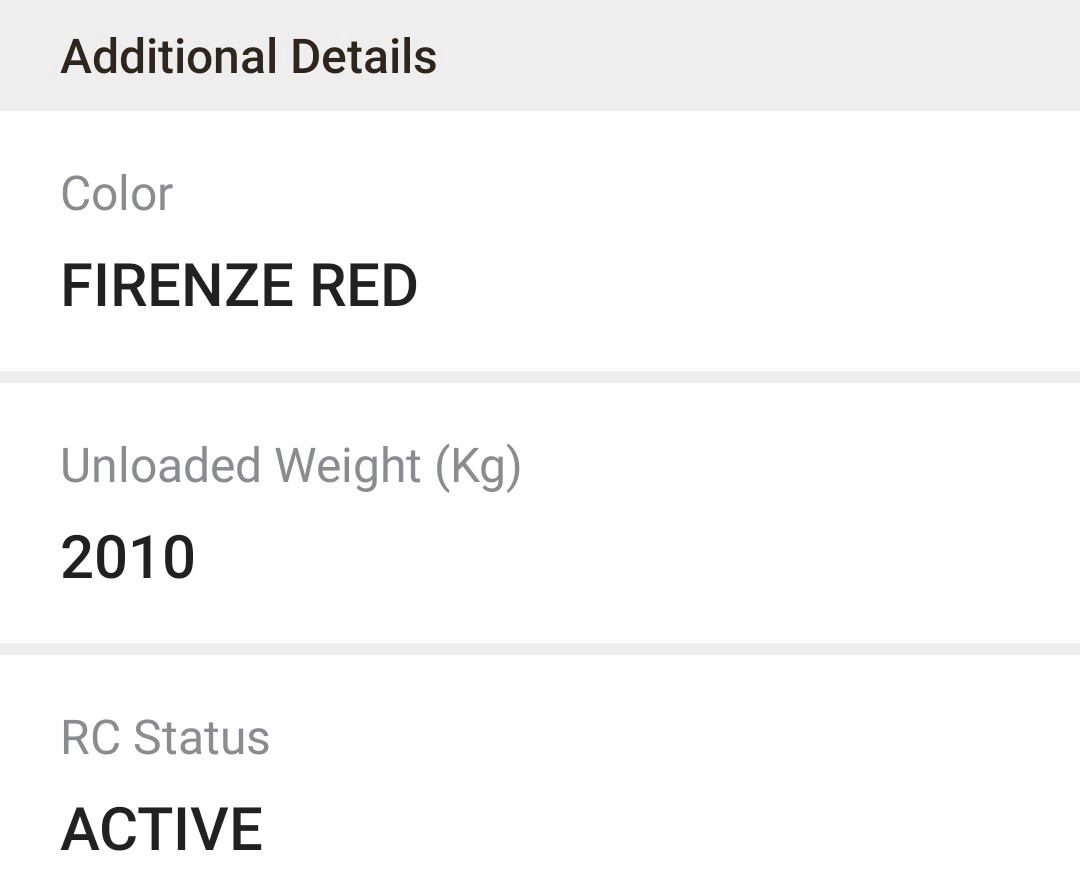


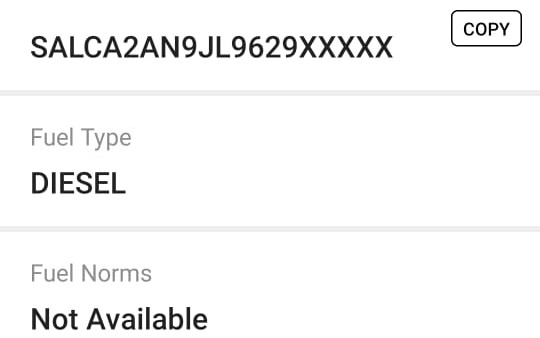


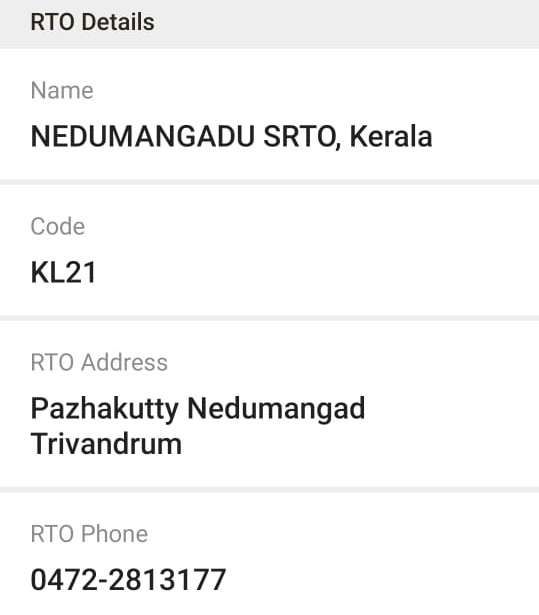

In [17]:
print("More details for vehicle Numbers:")
print("-----------------------------------------------------------------------")

print("Vehicle Number: ","CG 04 MF 2250")
for i in range(1,7):
    img = cv2.imread("screenshots/"+"q"+str(i)+".jpeg")
    fg=plt.imshow(img)
    fg.show()
    
print("-----------------------------------------------------------------------")

print("Vehicle Number: ","DL 3C AM 0857")
for i in range(7,14):
    img = cv2.imread("screenshots/"+"q"+str(i)+".jpeg")
    fg=plt.imshow(img)
    fg.show()
    
print("-----------------------------------------------------------------------")

print("Vehicle Number: ","KL 21S 8086")
for i in range(14,20):
    img = cv2.imread("screenshots/"+"q"+str(i)+".jpeg")
    fg=plt.imshow(img)
    fg.show()

In [ ]:
#thank you